In [38]:
# Import Required Libraries
from matplotlib import pyplot as plt
import numpy as np
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

import seaborn as sn
import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import csv

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=ConvergenceWarning)
simplefilter(action='ignore', category=UndefinedMetricWarning)

# Set Up Classification Models
- gnb = Gaussian Naive Bayes
- base_t = Default Decision tree
- per = Perceptron
- base_mlp = Default Multi-Layer Perceptron

In [39]:
# Initialize Models
gnb = GaussianNB()
base_t = tree.DecisionTreeClassifier(criterion="entropy")
per = Perceptron()
base_mlp = MLPClassifier(hidden_layer_sizes=(100,), activation="logistic", solver="sgd")

# Debug
debug = False

# Data Imports
### Imports the data from data 1 and data 2

In [40]:
# Import Data
test_data_1 = np.genfromtxt('./data 1/test_no_label_1.csv', delimiter=',')
test_data_2 = np.genfromtxt('./data 2/test_no_label_2.csv', delimiter=',')

labeled_test_data_1 = np.genfromtxt('./data 1/test_with_label_1.csv', delimiter=',')
labeled_test_data_2 = np.genfromtxt('./data 2/test_with_label_2.csv', delimiter=',')

train_data_1 = np.genfromtxt('./data 1/train_1.csv', delimiter=',')
train_data_2 = np.genfromtxt('./data 2/train_2.csv', delimiter=',')

val_data_1 = np.genfromtxt('./data 1/val_1.csv', delimiter=',')
val_data_2 = np.genfromtxt('./data 2/val_2.csv', delimiter=',')

# Parse Data
x_train_1 = train_data_1[ :, :-1]
y_train_1 = train_data_1[ :, -1]

x_test_1 = labeled_test_data_1[ :, :-1]
y_test_1 = labeled_test_data_1[ :, -1]

x_val_1 = val_data_1[ :, :-1]
y_val_1 = val_data_1[ :, -1]

x_train_2 = train_data_2[ :, :-1]
y_train_2 = train_data_2[ :, -1]

x_test_2 = labeled_test_data_2[ :, :-1]
y_test_2 = labeled_test_data_2[ :, -1]

x_val_2 = val_data_2[ :, :-1]
y_val_2 = val_data_2[ :, -1]

# Reference Dictionaries
### Sets up dictionaries to translate values to symbolic names ({0 : 'A', 1 : 'B', etc}

In [41]:
# Get Value Dictionaries
data_1 = {}
data_2 = {}

def readAndTranslate(inputFile, data_ref):
    with open(inputFile, mode='r') as infile:
        reader = csv.reader(infile)
        next(reader, None) # Skip header
        for rows in reader:
            data_ref[int(rows[0])] = rows[1]

readAndTranslate('data 1/info_1.csv', data_1)
readAndTranslate('data 2/info_2.csv', data_2)

# Plotting Utility Method
### Reusable method to return a scatter plot of frequency distributions for a given data set
- takes a dataset as input, and the plot title
    - gets labels for dataset by extracting last column of each row: data_labels
    - generates a tuple (count, label) for each label found
    - reduces list of tuples to a set to get one of each label only
    - assigns labels to x axis on data_x and counts to y axis on data_y

In [42]:
# Distribution Plot Methods
def distribution(data, title, ref):
    data_labels = [ref[(row[-1])] for row in data]
    tuples = sorted(set([(label, data_labels.count(label)) for label in data_labels]))
    
    if debug: 
        print(tuples)
    
    data_x = [x[0] for x in tuples]
    data_y = [y[1] for y in tuples]
    
    plt.scatter(data_x, data_y)
    plt.xlabel("Classes")
    plt.ylabel("Frequencies")
    plt.title(title)
    plt.show()

# Distributions for Data 1 and Data 2
- Training Set
- Labeled Test Set
- Validation Set

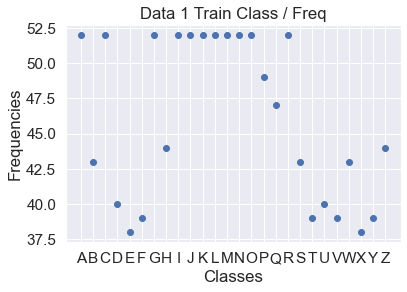

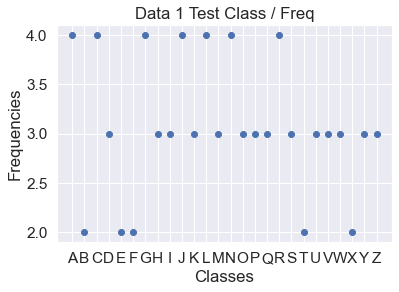

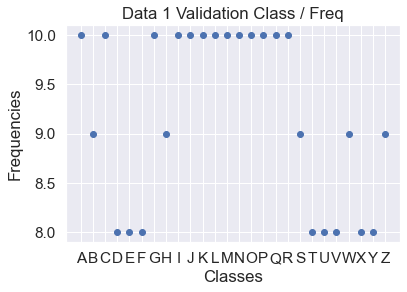

In [43]:
# Distributions for Data 1
distribution(train_data_1, "Data 1 Train Class / Freq", data_1)
distribution(labeled_test_data_1, "Data 1 Test Class / Freq", data_1)
distribution(val_data_1, "Data 1 Validation Class / Freq", data_1)

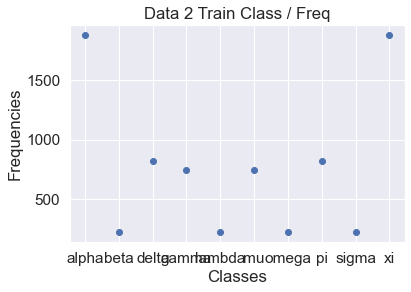

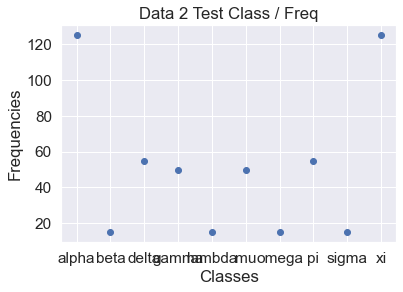

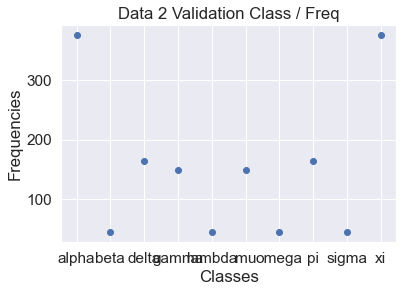

In [44]:
# Distributions for Data 2
distribution(train_data_2, "Data 2 Train Class / Freq", data_2)
distribution(labeled_test_data_2, "Data 2 Test Class / Freq", data_2)
distribution(val_data_2, "Data 2 Validation Class / Freq", data_2)

### Check Training Data for Noisey Input

In [45]:
def noiseyCheck(x_train, y_train):
    
    numDataPoints = len(x_train)
    duplicates = 0
    noiseyInput = 0
    
    x_dict = {}
    for i in range(numDataPoints-1):
        if x_train[i].tobytes() in x_dict:
            duplicates += 1
            if y_train[i] != x_dict[x_train[i].tobytes()]:
                noiseyInput += 1
        else:
            x_dict[x_train[i].tobytes()] = y_train[i]

    print(f'Number of Data Points: {numDataPoints}')
    print(f'Duplicates: {duplicates}')
    print(f'Noisey input: {noiseyInput}')
    

print("Data Set 1: ")
noiseyCheck(x_train_1, y_train_1)

print('\n')

print("Data Set 2: ")
noiseyCheck(x_train_2, y_train_2)

Data Set 1: 
Number of Data Points: 1197
Duplicates: 0
Noisey input: 0


Data Set 2: 
Number of Data Points: 7800
Duplicates: 0
Noisey input: 0


# General Model Testing/Training Procedure
### Training
- Split training data into features vectors (x_train) and label vector (y_train)
- Fit data to the model

### Testing
- Split test data into features vector (x_test) and label vector (y_test)
- Get label classification vector from trained model (prediction)

### Output
- Print actual labels
- Print model label predictions
- Print model label predictions to csv file
- Print prediction misses (comparision between prediction and y_test)
- Compare model label classification vector (prediction) to label vector (y_test)
    

# Analysis Utils

### Generate Confusion Matrix

In [46]:
def genConfusionMatrix(data_ref, y_test, prediction, outputPath):
    
    # get confusion matrix
    labels = list(data_ref.keys())
    array = confusion_matrix(y_test, prediction, labels)
        
    # append confusion matrix to csv
    with open(outputPath, "a") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(array)
            
    # plot confusion matrix: evaluates the quality of the output of the classifier
    print("\n" + "Confusion matrix:")
    df_cm = pd.DataFrame(array, range(len(data_ref.keys())), range(len(data_ref.keys())))
    plt.figure(figsize=(12,10))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.show()

### Write Classifcation Report to csv

In [47]:
def writeClassifcationReport(y_test, prediction, outputPath):
    clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
    clsf_report.to_csv(outputPath, index= True)

### Write Predictions to csv

In [48]:
def writePredictions(outputPath, prediction):
    with open(outputPath, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for entry in range(prediction.size):
            writer.writerow([entry, int(prediction[entry])])

### Get and Print Report

In [49]:
def getReport(y_test, prediction):
    print("\n" + "Classification report:")
    report = classification_report(y_test, prediction)
    print(report)
    report = classification_report(y_test, prediction, output_dict=True)
    return report

### Print Debug

In [50]:
def printDebug(data_ref, y_test, prediction):
    print([(entry, data_ref[prediction[entry]]) for entry in range(prediction.size)])
    print([(entry, data_ref[y_test[entry]]) for entry in range(y_test.size)])

### Print Accuracy

In [51]:
def printAccuracy(y_test, prediction):
    print(f'Accuracy: {100*((y_test == prediction).sum()/len(y_test))}%')

### Run Evaluation Metrics

In [52]:
# Wrapper function for Analysis Utils
def runEvaluationMetrics(y_test, prediction, outfile, data_ref):
    
    printAccuracy(y_test, prediction)

    outputPath = 'output/' + outfile
    
    # write classification report
    writeClassifcationReport(y_test, prediction, outputPath)
    
    # write the predictions
    writePredictions(outputPath, prediction)

    # generate confusion matrix
    genConfusionMatrix(data_ref, y_test, prediction, outputPath)

    # show precision, recall, f1-score, etc
    report = getReport(y_test, prediction)

    return report

# Gaussian Naive Bayes

#### Define Model

In [53]:
def runGNB(x_train, y_train, x_test, y_test, data_ref, outfile):

    gnb.fit(x_train, y_train)

    prediction = gnb.predict(x_test)
    
    if debug:
        printDebug(data_ref, y_test, prediction)
    
    report = runEvaluationMetrics(y_test, prediction, outfile, data_ref)
    
    return report

### Run GNB on Data Set 1

Accuracy: 68.75%

Confusion matrix:

Classification report:
              precision    recall  f1-score   support

         0.0       0.50      0.50      0.50         4
         1.0       0.33      1.00      0.50         2
         2.0       1.00      0.75      0.86         4
         3.0       0.67      0.67      0.67         3
         4.0       0.00      0.00      0.00         2
         5.0       0.50      0.50      0.50         2
         6.0       0.67      0.50      0.57         4
         7.0       1.00      0.33      0.50         3
         8.0       1.00      1.00      1.00         3
         9.0       1.00      0.50      0.67         4
        10.0       0.50      0.33      0.40         3
        11.0       1.00      0.75      0.86         4
        12.0       0.29      0.67      0.40         3
        13.0       0.60      0.75      0.67         4
        14.0       1.00      1.00      1.00         3
        15.0       1.00      0.67      0.80         3
        16.0       0.

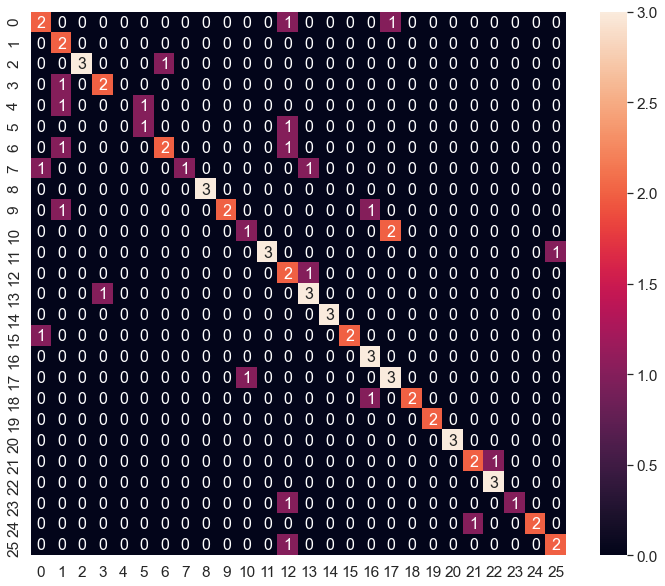

In [54]:
# GNB-DS1
GNB1Report = runGNB(x_train_1, y_train_1, x_test_1, y_test_1, data_1, 'GNB-DS1.csv')

### Run GNB on Data Set 2

Accuracy: 66.92307692307692%

Confusion matrix:

Classification report:
              precision    recall  f1-score   support

         0.0       0.60      0.47      0.53        55
         1.0       0.93      0.89      0.91       125
         2.0       0.28      0.80      0.41        15
         3.0       0.34      0.93      0.50        15
         4.0       0.59      0.40      0.48        50
         5.0       0.76      0.62      0.68        55
         6.0       0.24      0.73      0.37        15
         7.0       1.00      0.93      0.97        15
         8.0       0.88      0.30      0.45        50
         9.0       0.77      0.73      0.75       125

    accuracy                           0.67       520
   macro avg       0.64      0.68      0.60       520
weighted avg       0.75      0.67      0.68       520



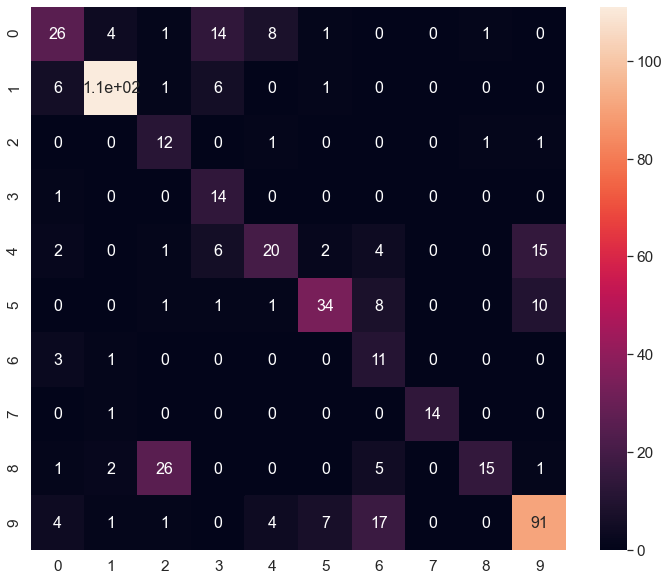

In [55]:
# GNB-DS2
GNB2Report = runGNB(x_train_2, y_train_2, x_test_2, y_test_2, data_2, 'GNB-DS2.csv')

# Baseline Decision Trees
### Parameters
- splitting criterion: entropy
- maximum depth: none
- min # of samples to split an internal node: 2
- min impurity decrease: 0.0
- class weight: none

### Define Model

In [56]:
def runBaseDT(x_train, y_train, x_test, y_test, data_ref, outfile):
    
    base_t.fit(x_train, y_train)

    prediction = base_t.predict(x_test)
    
    if debug:
        printDebug(data_ref, y_test, prediction)
    
    report = runEvaluationMetrics(y_test, prediction, outfile, data_ref)
    
    return report

### Run Base DT on Data Set 1

Accuracy: 46.25%

Confusion matrix:

Classification report:
              precision    recall  f1-score   support

         0.0       0.43      0.75      0.55         4
         1.0       0.00      0.00      0.00         2
         2.0       0.75      0.75      0.75         4
         3.0       0.50      0.33      0.40         3
         4.0       0.33      0.50      0.40         2
         5.0       0.50      0.50      0.50         2
         6.0       0.00      0.00      0.00         4
         7.0       1.00      0.33      0.50         3
         8.0       0.50      0.33      0.40         3
         9.0       0.50      0.75      0.60         4
        10.0       0.00      0.00      0.00         3
        11.0       0.75      0.75      0.75         4
        12.0       0.00      0.00      0.00         3
        13.0       0.40      0.50      0.44         4
        14.0       0.60      1.00      0.75         3
        15.0       0.25      0.33      0.29         3
        16.0       0.

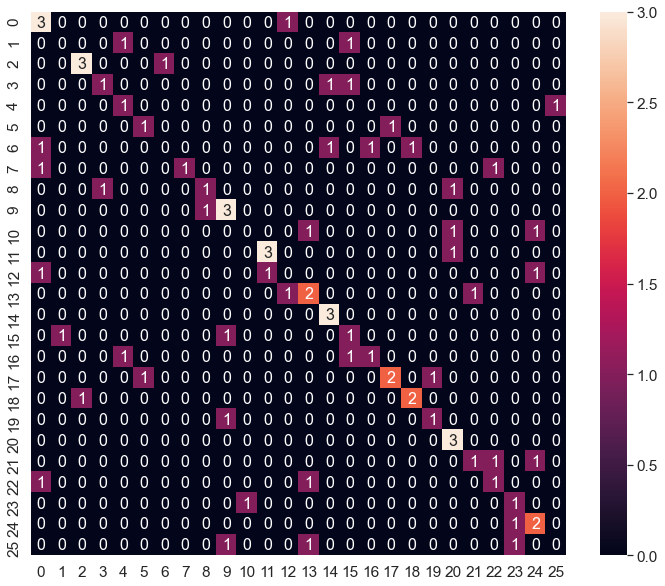

In [57]:
# Base-DT-DS1
BaseDT1Report = runBaseDT(x_train_1, y_train_1, x_test_1, y_test_1, data_1, 'Base-DT-DS1.csv')

### Run Base DT on Data Set 2

Accuracy: 77.3076923076923%

Confusion matrix:

Classification report:
              precision    recall  f1-score   support

         0.0       0.83      0.82      0.83        55
         1.0       0.92      0.92      0.92       125
         2.0       0.46      0.40      0.43        15
         3.0       0.53      0.60      0.56        15
         4.0       0.51      0.48      0.49        50
         5.0       0.72      0.76      0.74        55
         6.0       0.70      0.47      0.56        15
         7.0       0.93      0.87      0.90        15
         8.0       0.77      0.82      0.80        50
         9.0       0.78      0.80      0.79       125

    accuracy                           0.77       520
   macro avg       0.72      0.69      0.70       520
weighted avg       0.77      0.77      0.77       520



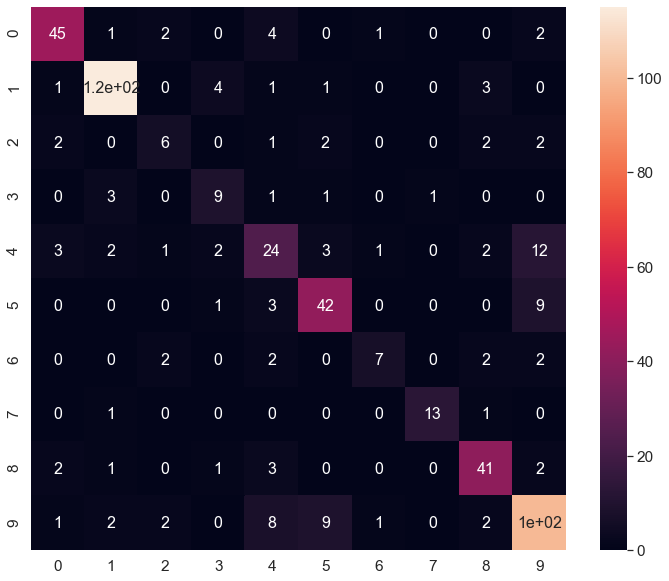

In [58]:
# Base-DT-DS2
BaseDT2Report = runBaseDT(x_train_2, y_train_2, x_test_2, y_test_2, data_2, 'Base-DT-DS2.csv')

# Optimized Decision Trees
### Parameters
- splitting criterion: gini / entropy
- maximum depth: 10 / no max
- min # of samples to split an internal node: range(1/10^100 - 1/10^110)
- min impurity decrease: range(1/10^100 - 1/10^110)
- class weight: none / balanced
### Brute Force Optimization Process
- Trains new tree with different h-parameter to determine best performance
    - Loops through a variety of parameters, tracking the best case of predictions misses (best)
- Findings
    - Entropy as a split criterion is the best h-parameter
    - No max depth for the tree is the best h-parameter
    - Balanced class weights is the best h-parameter
    - Min Samples Split works best at very small numbers
        - testing with range down to 1/100000
    - Min Impurity Decrease works best at very small numbers
        - testing with range down to 1/100000

### Define Model

In [59]:
def runBestDT(x_train, y_train, x_test, y_test, x_val, y_val, data_ref, base, outfile):
    
    def tree_score(sample, impurity):
        best_tree = tree.DecisionTreeClassifier(criterion="entropy", # Entropy is the best split criterion
                                           max_depth=None, # No max depth is best h-parameter
                                           min_samples_split=sample, # Small numbers here for best predictions
                                           min_impurity_decrease=impurity, # Small numbers here for best predictions
                                           class_weight="balanced") # Balanced class weights is the best h-paramter
        best_tree.fit(x_train, y_train)
        pred = best_tree.predict(x_val)
        return (y_val != pred).sum()

    tuned_samples = 0
    tuned_impurities = 0
    
    best = base

    for samples in [1/(10**x) for x in range(100, 110, 1)]: # Min Number of Samples
        for impurities in [1/(10**y) for y in range(100, 110, 1)]: # Min Impurity 
            # Decrease
                missed = tree_score(samples, impurities)
                if missed < best:
                    print(f'Splitting Criterion: Entropy\n'
                          f'Max Depth: None\n'
                          f'Min # Samples: {samples}\n'
                          f'Min Impurity Decrease:{impurities}\n'
                          f'Class Weights: Balanced')
                    tuned_samples = samples
                    tuned_impurities = impurities
                    best = missed
                    print(f'Accuracy: {100-(100*missed/base)}%')
                    print('\n')

    tuned = tree.DecisionTreeClassifier(
        criterion="entropy", # Entropy is the best split criterion                                   
        max_depth=None, # No max depth is best h-parameter
        min_samples_split=tuned_samples, # Small numbers here for best predictions
        min_impurity_decrease=tuned_impurities, # Small numbers here for best predictions
        class_weight="balanced")

    prediction = tuned.fit(x_train, y_train).predict(x_test)
    
    report = runEvaluationMetrics(y_test, prediction, outfile, data_ref)
    
    return report

### Run Best DT on Data Set 1

Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-100
Min Impurity Decrease:1e-100
Class Weights: Balanced
Accuracy: 44.76987447698745%


Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-100
Min Impurity Decrease:1e-103
Class Weights: Balanced
Accuracy: 46.02510460251046%


Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-102
Min Impurity Decrease:1e-101
Class Weights: Balanced
Accuracy: 46.86192468619247%


Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-109
Min Impurity Decrease:1e-103
Class Weights: Balanced
Accuracy: 48.11715481171548%


Accuracy: 51.24999999999999%

Confusion matrix:

Classification report:
              precision    recall  f1-score   support

         0.0       0.60      0.75      0.67         4
         1.0       0.00      0.00      0.00         2
         2.0       0.80      1.00      0.89         4
         3.0       0.50      0.33      0.40         3
         4.0       0.50      0.50      0.50         2

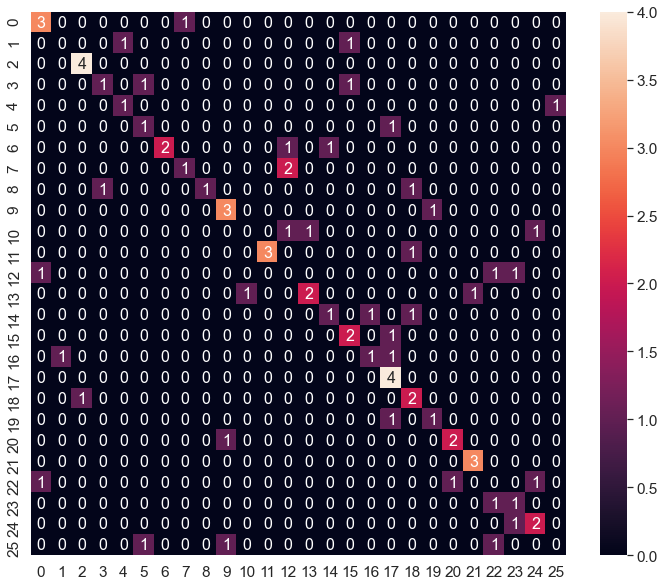

In [60]:
# Tree Optimization DS1
BestDT1Report = runBestDT(x_train_1, y_train_1, x_test_1, y_test_1, x_val_1, y_val_1, data_1, 239, 'Best-DT-DS1.csv')

### Run Best DT on Data Set 2

Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-100
Min Impurity Decrease:1e-100
Class Weights: Balanced
Accuracy: 76.21794871794872%


Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-100
Min Impurity Decrease:1e-101
Class Weights: Balanced
Accuracy: 76.34615384615384%


Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-100
Min Impurity Decrease:1e-106
Class Weights: Balanced
Accuracy: 76.73076923076923%


Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-100
Min Impurity Decrease:1e-109
Class Weights: Balanced
Accuracy: 77.05128205128204%


Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-101
Min Impurity Decrease:1e-109
Class Weights: Balanced
Accuracy: 77.11538461538461%


Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-105
Min Impurity Decrease:1e-101
Class Weights: Balanced
Accuracy: 77.37179487179488%


Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-107
Min Impurity Decrease:1e-10

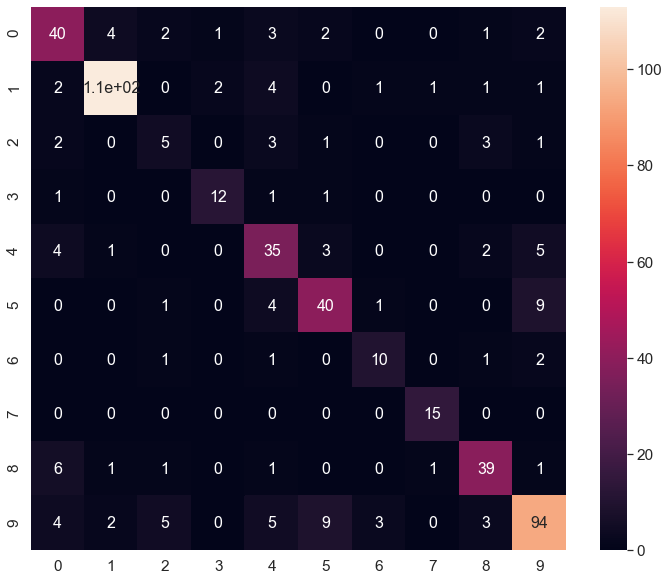

In [61]:
# Tree Optimization DS2
BestDT2Report = runBestDT(x_train_2, y_train_2, x_test_2, y_test_2, x_val_2, y_val_2, data_2, 1560, 'Best-DT-DS2.csv')

# Perceptrons

### Define Model

In [62]:
def runPer(x_train, y_train, x_test, y_test, data_ref, outfile):

    per.fit(x_train, y_train)

    prediction = per.predict(x_test)
    
    if debug:
        printDebug(data_ref, y_test, prediction)
    
    report = runEvaluationMetrics(y_test, prediction, outfile, data_ref)
    
    return report

### Run Perceptron on Data Set 1

Accuracy: 77.5%

Confusion matrix:

Classification report:
              precision    recall  f1-score   support

         0.0       0.60      0.75      0.67         4
         1.0       1.00      1.00      1.00         2
         2.0       1.00      0.75      0.86         4
         3.0       1.00      1.00      1.00         3
         4.0       1.00      1.00      1.00         2
         5.0       0.33      0.50      0.40         2
         6.0       1.00      0.75      0.86         4
         7.0       0.33      0.33      0.33         3
         8.0       1.00      1.00      1.00         3
         9.0       0.75      0.75      0.75         4
        10.0       0.33      0.33      0.33         3
        11.0       0.80      1.00      0.89         4
        12.0       0.50      0.33      0.40         3
        13.0       1.00      1.00      1.00         4
        14.0       1.00      1.00      1.00         3
        15.0       0.75      1.00      0.86         3
        16.0       0.7

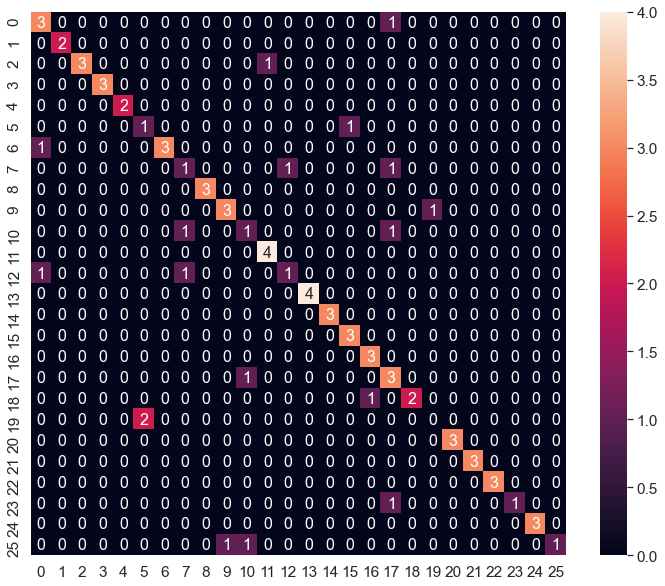

In [63]:
#PER-DS1
PER1Report = runPer(x_train_1, y_train_1, x_test_1, y_test_1, data_1, 'PER-DS1.csv')

### Run Perceptron on Data Set 2

Accuracy: 83.84615384615385%

Confusion matrix:

Classification report:
              precision    recall  f1-score   support

         0.0       0.68      0.95      0.79        55
         1.0       0.92      0.97      0.95       125
         2.0       0.73      0.53      0.62        15
         3.0       0.88      0.93      0.90        15
         4.0       0.77      0.54      0.64        50
         5.0       0.82      0.89      0.85        55
         6.0       0.83      0.33      0.48        15
         7.0       1.00      1.00      1.00        15
         8.0       0.81      0.84      0.82        50
         9.0       0.88      0.82      0.85       125

    accuracy                           0.84       520
   macro avg       0.83      0.78      0.79       520
weighted avg       0.84      0.84      0.83       520



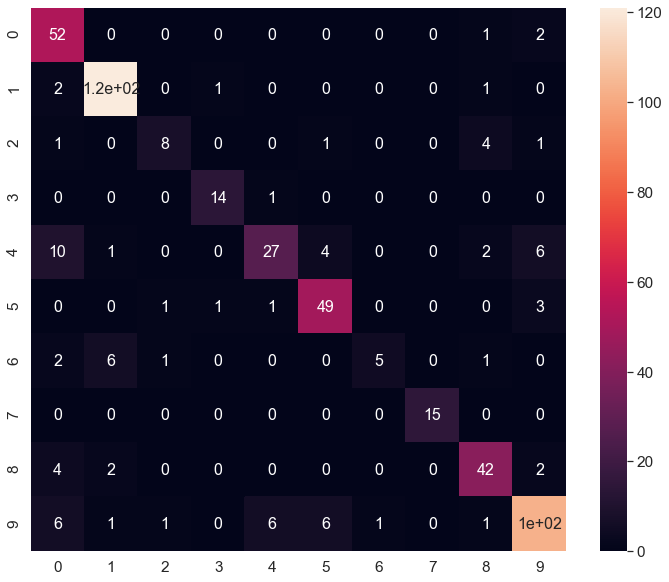

In [64]:
#PER-DS2
PER2Report = runPer(x_train_2, y_train_2, x_test_2, y_test_2, data_2, 'PER-DS2.csv')

# Baseline Multilayer Perceptrons
### Parameters
- 1 hidden layer of 100 neurons
- logistic as activation function
- stochastic gradient descent
- default values for the rest of the parameters

### Define Model

In [65]:
def runBaseMLP(x_train, y_train, x_test, y_test, data_ref, outfile):
    
    base_mlp.fit(x_train, y_train)

    prediction = base_mlp.predict(x_test)
    
    if debug:
        printDebug(data_ref, y_test, prediction)
    
    report = runEvaluationMetrics(y_test, prediction, outfile, data_ref)
    
    return report

### Run Base MLP on Data Set 1 

Accuracy: 38.75%

Confusion matrix:

Classification report:
              precision    recall  f1-score   support

         0.0       0.50      0.50      0.50         4
         1.0       0.00      0.00      0.00         2
         2.0       0.43      0.75      0.55         4
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00      0.00         2
         5.0       0.00      0.00      0.00         2
         6.0       0.50      0.75      0.60         4
         7.0       1.00      0.33      0.50         3
         8.0       0.38      1.00      0.55         3
         9.0       1.00      0.50      0.67         4
        10.0       0.22      0.67      0.33         3
        11.0       0.25      0.50      0.33         4
        12.0       0.29      0.67      0.40         3
        13.0       0.67      0.50      0.57         4
        14.0       0.27      1.00      0.43         3
        15.0       1.00      0.33      0.50         3
        16.0       1.

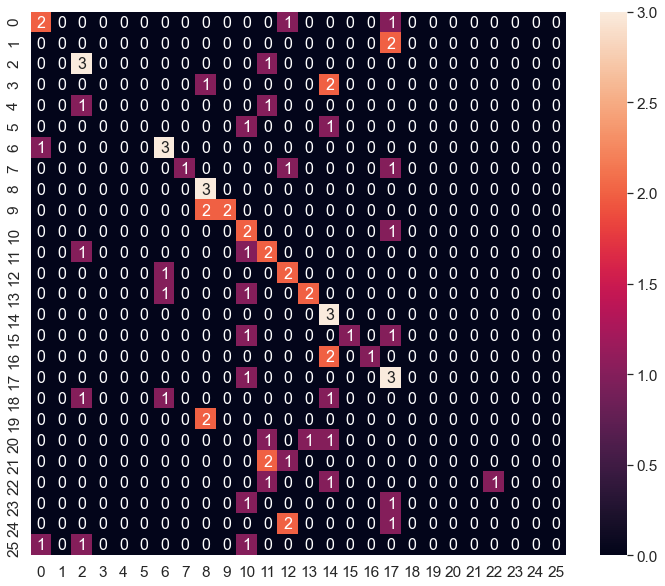

In [66]:
#Base-MLP-DS1
BaseMLP1Report = runBaseMLP(x_train_1, y_train_1, x_test_1, y_test_1, data_1, 'Base-MLP-DS1.csv')

### Run Base MLP on Data Set 2

Accuracy: 83.65384615384616%

Confusion matrix:

Classification report:
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.81        55
         1.0       0.94      0.96      0.95       125
         2.0       0.75      0.40      0.52        15
         3.0       0.92      0.73      0.81        15
         4.0       0.74      0.56      0.64        50
         5.0       0.81      0.91      0.85        55
         6.0       1.00      0.33      0.50        15
         7.0       1.00      1.00      1.00        15
         8.0       0.75      0.88      0.81        50
         9.0       0.81      0.88      0.84       125

    accuracy                           0.84       520
   macro avg       0.85      0.75      0.77       520
weighted avg       0.84      0.84      0.83       520



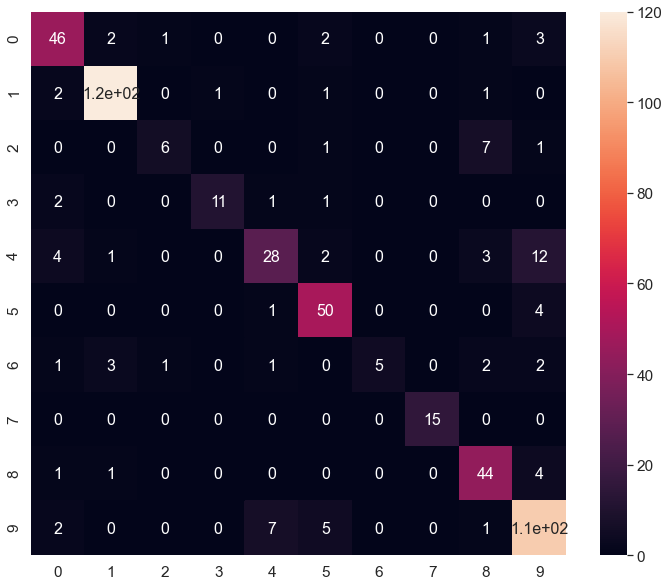

In [67]:
#Base-MLP-DS2
BaseMLP2Report = runBaseMLP(x_train_2, y_train_2, x_test_2, y_test_2, data_2, 'Base-MLP-DS2.csv')

# Optimized Multilayer Perceptrons
### Paramters
- 2 hidden layers with 30+50 nodes / 3 hidden layers with 10+10 nodes
- logistic/tanh/relu/identity as activation function
- stochastic gradient descent / Adam
- default values for the rest of the parameters
### Brute Force Optimization Process
- Trains new MLP with different h-parameter to determine best performance
    - Loops through a variety of parameters, tracking the best case of predictions misses (best)

### Define Model

In [68]:
def runBestMLP(x_train, y_train, x_test, y_test, x_val, y_val, data_ref, samples, outfile):
    
    best = samples
    def mlp_score(layer, funct, solver):
        best_mlp = MLPClassifier(hidden_layer_sizes=layer, activation=funct, solver=solver)
        best_mlp.fit(x_train, y_train)
        pred = best_mlp.predict(x_val)
        return (y_val != pred).sum()

    layers = [(30, 50), (10, 10, 10)]
    functions = ["logistic", "tanh", "relu", "identity"]
    solvers = ["sgd", "adam"]

    tuned_layers = None
    tuned_function = None
    tuned_solver = None

    for layer in layers:
        for function in functions:
            for solver in solvers:
                missed = mlp_score(layer, function, solver)
                if missed < best:
                    print(f'Layers: {layer}\n'
                          f'Activation Function: {function}\n'
                          f'Solver: {solver}')
                    tuned_layers = layer
                    tuned_function = function
                    tuned_solver = solver
                    best = missed
                    print(f'Accuracy: {100-(100*missed/samples)}%')
                    print('\n')

    tuned = MLPClassifier(hidden_layer_sizes=tuned_layers, activation=tuned_function, solver=tuned_solver)

    prediction = tuned.fit(x_train, y_train).predict(x_test)
    
    report = runEvaluationMetrics(y_test, prediction, outfile, data_ref)
    
    return report

### Run Best MLP on Data Set 1 

Layers: (30, 50)
Activation Function: logistic
Solver: sgd
Accuracy: 4.60251046025104%


Layers: (30, 50)
Activation Function: logistic
Solver: adam
Accuracy: 78.24267782426779%


Layers: (30, 50)
Activation Function: tanh
Solver: adam
Accuracy: 80.3347280334728%


Layers: (30, 50)
Activation Function: identity
Solver: adam
Accuracy: 82.84518828451883%


Accuracy: 85.0%

Confusion matrix:

Classification report:
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86         4
         1.0       0.50      1.00      0.67         2
         2.0       1.00      1.00      1.00         4
         3.0       1.00      1.00      1.00         3
         4.0       1.00      0.50      0.67         2
         5.0       1.00      0.50      0.67         2
         6.0       1.00      0.75      0.86         4
         7.0       1.00      1.00      1.00         3
         8.0       0.75      1.00      0.86         3
         9.0       1.00      0.50      0.67

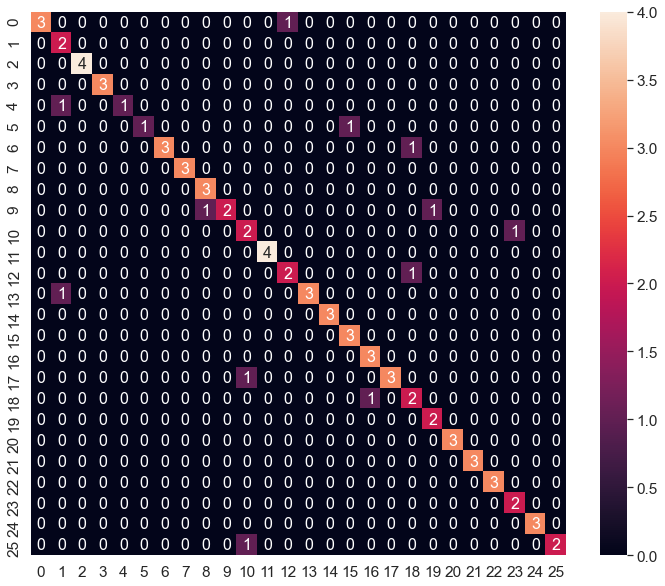

In [69]:
# MLP Optimization DS1
BestMLP1Report = runBestMLP(x_train_1, y_train_1, x_test_1, y_test_1, x_val_1, y_val_1, data_1, 239, 'Best-MLP-DS1.csv')

### Run Best MLP on Data Set 2

Layers: (30, 50)
Activation Function: logistic
Solver: sgd
Accuracy: 61.6025641025641%


Layers: (30, 50)
Activation Function: logistic
Solver: adam
Accuracy: 88.58974358974359%


Layers: (30, 50)
Activation Function: tanh
Solver: sgd
Accuracy: 89.61538461538461%


Accuracy: 87.6923076923077%

Confusion matrix:

Classification report:
              precision    recall  f1-score   support

         0.0       0.80      0.95      0.87        55
         1.0       0.95      0.97      0.96       125
         2.0       0.64      0.60      0.62        15
         3.0       0.87      0.87      0.87        15
         4.0       0.79      0.76      0.78        50
         5.0       0.85      0.95      0.90        55
         6.0       1.00      0.53      0.70        15
         7.0       0.94      1.00      0.97        15
         8.0       0.82      0.90      0.86        50
         9.0       0.93      0.82      0.87       125

    accuracy                           0.88       520
   macro avg 

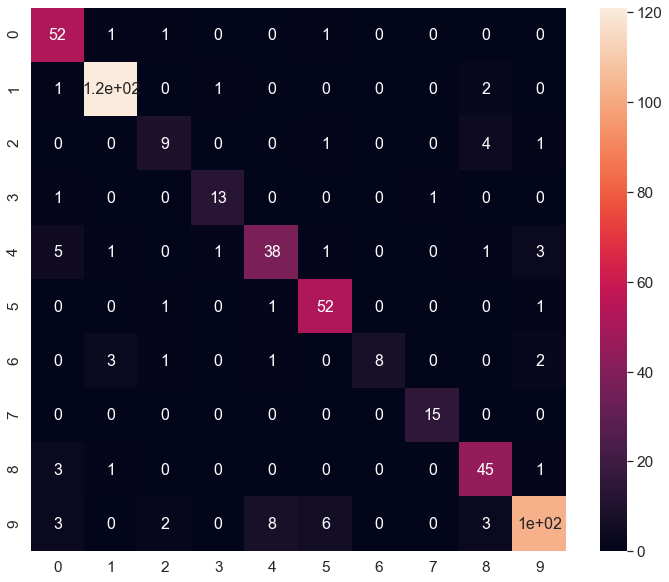

In [70]:
# MLP Optimization DS2
BestMLP2Report = runBestMLP(x_train_2, y_train_2, x_test_2, y_test_2, x_val_2, y_val_2, data_2, 1560, 'Best-MLP-DS2.csv')

# Experiment findings

### Comparison Graphing Function

In [71]:
def compare(report, name):
    data_x = [x[1] for x in report]
    data_y = [y[0] for y in report]
    
    plt.scatter(data_x, data_y)
    plt.xlabel("Score")
    plt.ylabel("Models")
    plt.title("Cross Model Comparison of " + name)
    plt.xlim(0,1)
    plt.show()

def label(metric):
    return float("{:.2f}".format(metric))

### Compare Models by Metric

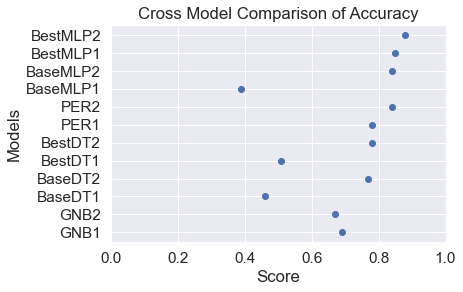

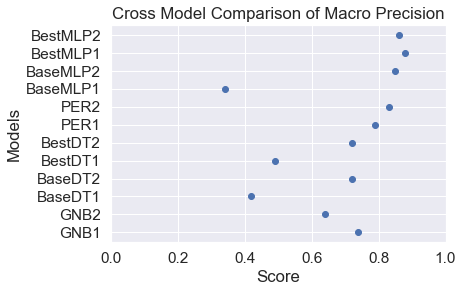

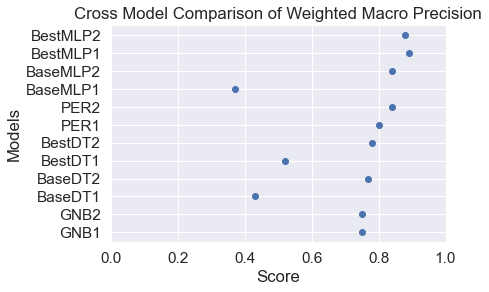

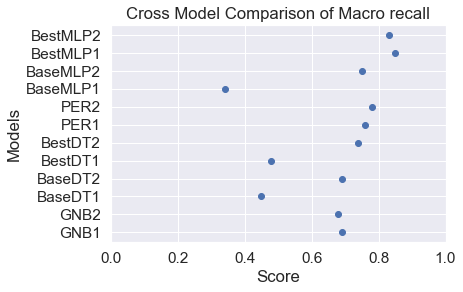

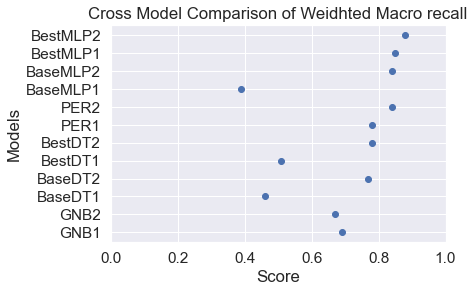

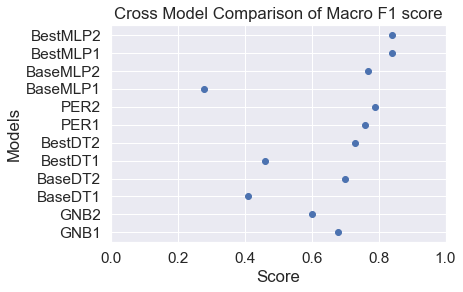

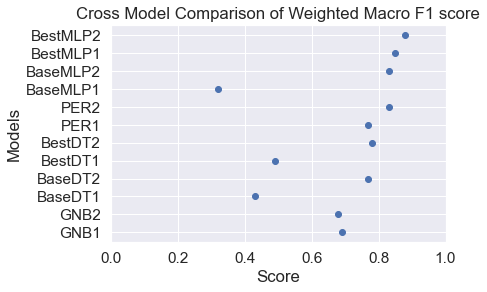

In [72]:
reports = [("GNB1", GNB1Report), ("GNB2", GNB2Report), 
           ("BaseDT1", BaseDT1Report), ("BaseDT2", BaseDT2Report),
           ("BestDT1", BestDT1Report), ("BestDT2", BestDT2Report),
           ("PER1", PER1Report), ("PER2", PER2Report),
           ("BaseMLP1", BaseMLP1Report), ("BaseMLP2", BaseMLP2Report),
           ("BestMLP1", BestMLP1Report), ("BestMLP2", BestMLP2Report)]

accuracy = [(model[0], label(model[1]['accuracy'])) for model in reports]

macro_precision = [(model[0], label(model[1]['macro avg']['precision'])) for model in reports]
macro_recall = [(model[0], label(model[1]['macro avg']['recall'])) for model in reports]
macro_f1 = [(model[0], label(model[1]['macro avg']['f1-score'])) for model in reports]

w_macro_precision = [(model[0], label(model[1]['weighted avg']['precision'])) for model in reports]
w_macro_recall = [(model[0], label(model[1]['weighted avg']['recall'])) for model in reports]
w_macro_f1 = [(model[0], label(model[1]['weighted avg']['f1-score'])) for model in reports]

    
# Accuracy
compare(accuracy, "Accuracy")
print("\n\n")
# Macro vs Weighted
compare(macro_precision, "Macro Precision")
compare(w_macro_precision, "Weighted Macro Precision")
print("\n\n")
compare(macro_recall, "Macro recall")
compare(w_macro_recall, "Weidhted Macro recall")
print("\n\n")
compare(macro_f1, "Macro F1 score")
compare(w_macro_f1, "Weighted Macro F1 score")

## Compare Models by Data Set

### Data Set 1

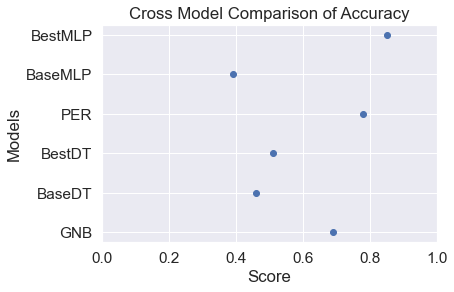

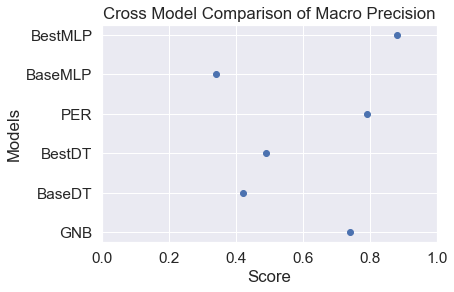

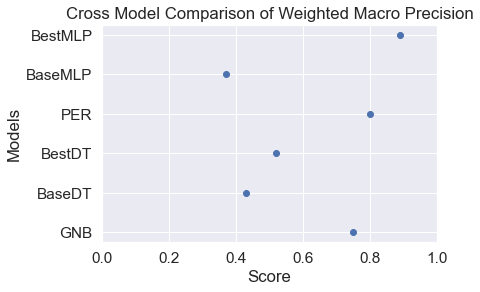

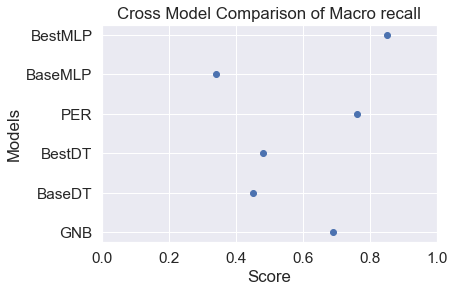

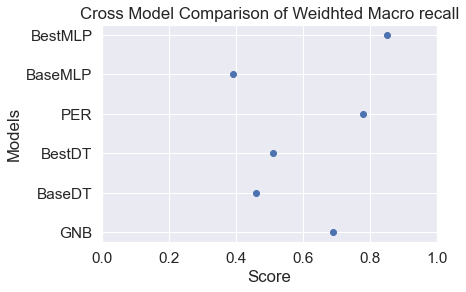

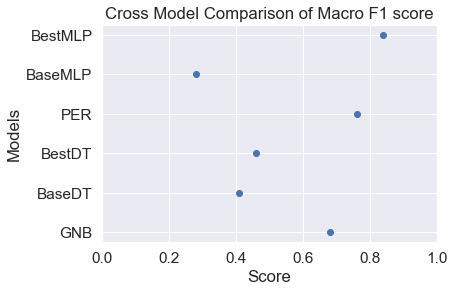

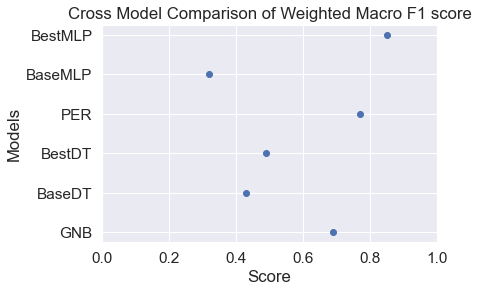

In [73]:
ds_1_reports = [("GNB", GNB1Report), 
                      ("BaseDT", BaseDT1Report),
                      ("BestDT", BestDT1Report),
                      ("PER", PER1Report),
                      ("BaseMLP", BaseMLP1Report),
                      ("BestMLP", BestMLP1Report)]

ds_1_accuracy = [(model[0], label(model[1]['accuracy'])) for model in ds_1_reports]

ds_1_macro_precision = [(model[0], label(model[1]['macro avg']['precision'])) for model in ds_1_reports]
ds_1_macro_recall = [(model[0], label(model[1]['macro avg']['recall'])) for model in ds_1_reports]
ds_1_macro_f1 = [(model[0], label(model[1]['macro avg']['f1-score'])) for model in ds_1_reports]

ds_1_w_macro_precision = [(model[0], label(model[1]['weighted avg']['precision'])) for model in ds_1_reports]
ds_1_w_macro_recall = [(model[0], label(model[1]['weighted avg']['recall'])) for model in ds_1_reports]
ds_1_w_macro_f1 = [(model[0], label(model[1]['weighted avg']['f1-score'])) for model in ds_1_reports]


# Accuracy
compare(ds_1_accuracy, "Accuracy")
print("\n\n")
# Macro vs Weighted
compare(ds_1_macro_precision, "Macro Precision")
compare(ds_1_w_macro_precision, "Weighted Macro Precision")
print("\n\n")
compare(ds_1_macro_recall, "Macro recall")
compare(ds_1_w_macro_recall, "Weidhted Macro recall")
print("\n\n")
compare(ds_1_macro_f1, "Macro F1 score")
compare(ds_1_w_macro_f1, "Weighted Macro F1 score")

### Data Set 2

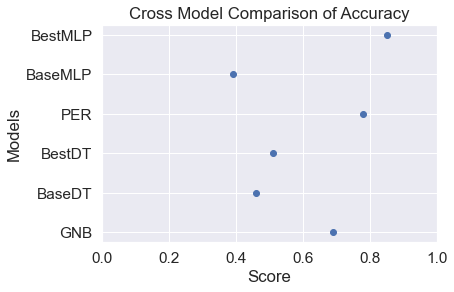

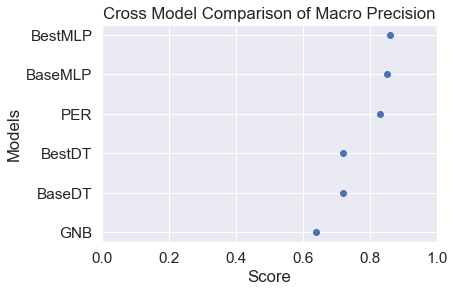

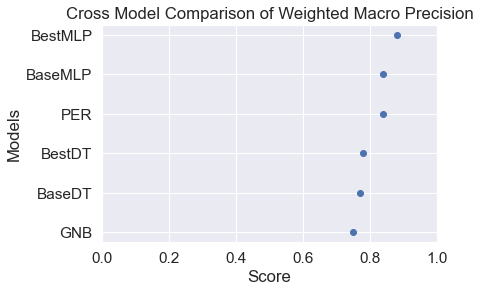

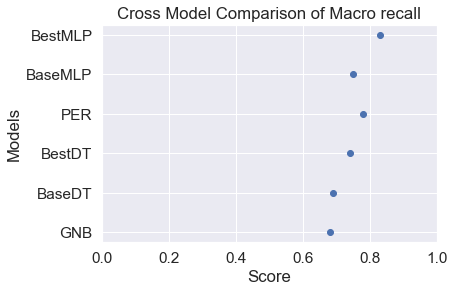

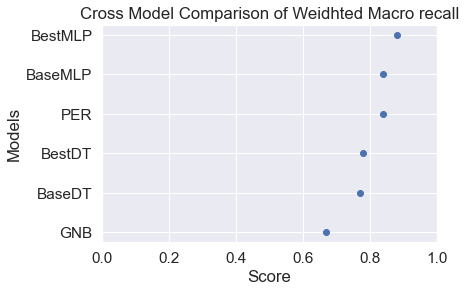

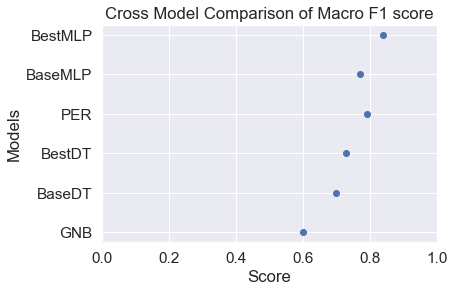

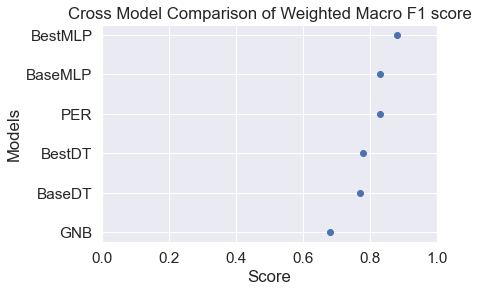

In [74]:
ds_2_reports = [("GNB", GNB2Report), 
                      ("BaseDT", BaseDT2Report),
                      ("BestDT", BestDT2Report),
                      ("PER", PER2Report),
                      ("BaseMLP", BaseMLP2Report),
                      ("BestMLP", BestMLP2Report)]

ds_2_accuracy = [(model[0], label(model[1]['accuracy'])) for model in ds_1_reports]

ds_2_macro_precision = [(model[0], label(model[1]['macro avg']['precision'])) for model in ds_2_reports]
ds_2_macro_recall = [(model[0], label(model[1]['macro avg']['recall'])) for model in ds_2_reports]
ds_2_macro_f1 = [(model[0], label(model[1]['macro avg']['f1-score'])) for model in ds_2_reports]

ds_2_w_macro_precision = [(model[0], label(model[1]['weighted avg']['precision'])) for model in ds_2_reports]
ds_2_w_macro_recall = [(model[0], label(model[1]['weighted avg']['recall'])) for model in ds_2_reports]
ds_2_w_macro_f1 = [(model[0], label(model[1]['weighted avg']['f1-score'])) for model in ds_2_reports]


# Accuracy
compare(ds_2_accuracy, "Accuracy")
print("\n\n")
# Macro vs weighted
compare(ds_2_macro_precision, "Macro Precision")
compare(ds_2_w_macro_precision, "Weighted Macro Precision")
print("\n\n")
compare(ds_2_macro_recall, "Macro recall")
compare(ds_2_w_macro_recall, "Weidhted Macro recall")
print("\n\n")
compare(ds_2_macro_f1, "Macro F1 score")
compare(ds_2_w_macro_f1, "Weighted Macro F1 score")